In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings


In [2]:
df = pd.read_csv("/hpi/fs00/home/lukas.laskowski/Masterarbeit/NumbER/NumbER/scripts/runs_restart_2_emb.csv")
warnings.simplefilter(action='ignore', category=FutureWarning)

embitto_filter= {
	'lr': 3e-5,
 	'should_finetune': True,
	'should_pretrain': False,
	'matching_solution': 'embitto',
	'finetune_batch_size': 50,
 	'num_finetune_epochs': 40,
	#'num_pretrain_epochs': ??,
	#'pretrain_batch_size': 50,
	'output_embedding_size': 256,
	#'include_numerical_features_in_textual': True,
	#'lm': 'roberta',
	#'fp16': True,
	#'max_len': 256,
	#'numerical_config_model': None,
	# 'numerical_config_model': "NumbER.matching_solutions.embitto.numerical_components.value_embeddings.ValueBaseEmbeddings",
	'numerical_config_model': "NumbER.matching_solutions.embitto.numerical_components.dice.DICEEmbeddingAggregator",
    'numerical_config_embedding_size': 128,
	# 'numerical_config_finetune_formatter': 'NumbER.matching_solutions.embitto.formatters.pair_based_numeric_formatter',
	# 'numerical_config_pretrain_formatter': 'NumbER.matching_solutions.embitto.formatters.dummy_formatter',
	# 'numerical_config_0': None,
	'textual_config_model': 'NumbER.matching_solutions.embitto.textual_components.base_roberta.BaseRoberta',
	'textual_config_max_length': 256,
	'textual_config_embedding_size': 128,
	'textual_config_finetune_formatter': 'NumbER.matching_solutions.embitto.formatters.complete_prompt_formatter',#_scientific',
	#'textual_config_pretrain_formatter': ??,
	#'textual_config_0': None, 
}

ditto_filter = {
	"batch_size": 50,
	"n_epochs": 40,
	"lr": 3e-5,
	"max_len": 256,
	"lm": "roberta",
	"fp16": True,
 	"matching_solution": "ditto",
}
deep_matcher_filter = {
	"batch_size": 50,
	"epochs": 40,
 	"matching_solution": "deep_matcher",
}
# Create the 3x3 grid of boxplots
#plt.figure(figsize=(12, 24))  # Adjust the figure size if needed
y_data = []
labels=[]
means = []
ditto_mean = 0.0
ditto_y_data = []
result_df = pd.DataFrame(columns=["dataset", "f1_not_closed", "recall_not_closed", "precision_not_closed", "training_time"])
# Iterate through each unique group and create a boxplot for each one
for i, group in enumerate([
    "value_embeddings.ValueBaseEmbeddings",
    "value_embeddings.ValueTransformerEmbeddings", "value_embeddings.ValueValueEmbeddings", "dice.DICEEmbeddingAggregator", #"deep_matcher", "ditto"
]):
    filtered_df = df
    if group == "ditto":
        filter = ditto_filter
    elif group == "deep_matcher":
        filter = deep_matcher_filter
    else:
        embitto_filter["numerical_config_model"] = f"NumbER.matching_solutions.embitto.numerical_components.{group}"
        filter = embitto_filter
    for key, value in filter.items():
        if value is not None:
            filtered_df = filtered_df[filtered_df[key] == value]
        else:
            filtered_df = filtered_df[filtered_df[key].isnull()]
    filtered_df = filtered_df.drop_duplicates(subset=['tags', 'dataset', 'run'])
    filtered_df = filtered_df[~filtered_df["run"].isnull()]
    #filtered_df = filtered_df[filtered_df['f1_not_closed'] is not None]
    #select only those rows where f1_not_closed is not nan
    filtered_df = filtered_df[filtered_df['f1_not_closed'].notna()]
    #filtered_df = filtered_df[filtered_df["dataset"].isin(["baby_products_numeric","books3_all","books3_numeric","books3_numeric_no_isbn","earthquakes","vsx_small","x2_all","x2_combined","x3_all","x3_combined","x3_numeric" ])]
    #NUMERICAL DATASETS
    datasets = ["baby_products_numeric","books3_numeric", "x2_numeric","x3_numeric","earthquakes","vsx_small", "protein_small", "2MASS_small_no_n"]
    filtered_df = filtered_df[filtered_df["dataset"].isin(datasets)]
    cols = filtered_df["dataset"].unique()
    for dataset in datasets:
        if dataset not in cols:
            filtered_df = filtered_df.append({"dataset": dataset, "f1_not_closed": 0, "recall_not_closed": 0, "precision_not_closed": 0, "training_time": 0}, ignore_index=True)
    #TEXTUAL DATASETS
    #filtered_df = filtered_df[filtered_df["dataset"].isin(["baby_products_all","baby_products_combined","books3_all", "books3_all_no_isbn","books3_combined","books3_combined_no_isbn","x2_all","x2_combined", "x3_all", "x3_combined"])]
    filtered_df['training_time'] = filtered_df['training_time'].apply(lambda x: -x/60)
    runs_per_dataset = filtered_df.groupby('dataset').size()    
    missing_runs = 5 - runs_per_dataset
    missing_datasets = missing_runs[missing_runs > 0]
    print("group",group)
    print("missing",missing_datasets)
    # 3. Create dummy data for missing runs
    rows_list = []
    for dataset, num_missing in missing_datasets.items():
        for i in range(num_missing):
            print(i)
            rows_list.append({'dataset': dataset, 'f1_not_closed': 0, 'recall_not_closed': 0, 'precision_not_closed': 0, 'training_time': 0})
    dummy_df = pd.DataFrame(rows_list)

    # 4. Append dummy data to original data
    filtered_df = pd.concat([filtered_df, dummy_df], ignore_index=True)
    aggregate = filtered_df.groupby(["dataset"]).agg({"f1_not_closed": ["mean", "std", "count"], "recall_not_closed": ["mean"], "precision_not_closed": ["mean"], "training_time": ["mean", "std"]})
    aggregate = aggregate[aggregate["f1_not_closed"]["count"] > 4]
    print(aggregate)
    for idx, row in aggregate.iterrows():
        if group == "ditto":
            solution = "SOTA"
        elif group == "deep_matcher":
            solution = "SOTA"
        else:
            solution = "NumbER"
        print(idx)
        result_df = result_df.append({"dataset": idx, "matching_solution": solution, "f1_not_closed": row["f1_not_closed"]["mean"], "recall_not_closed": row["recall_not_closed"]["mean"], "precision_not_closed": row["precision_not_closed"]["mean"], "training_time": row["training_time"]["mean"],"algorithm": group},  ignore_index=True)
    mean = aggregate['f1_not_closed'].mean()['mean']
    if group == "ditto":
        ditto_mean = mean
        ditto_y_data = aggregate['f1_not_closed']['mean'].values
        continue
    elif group == "deep_matcher":
        aggregate = filtered_df.groupby(["dataset"]).agg({"f1_reported": ["mean", "std", "count"], "recall_not_closed": ["mean"], "training_time": ["mean", "std"]})
        deep_matcher_mean = aggregate['f1_reported'].mean()['mean']
        deep_matcher_y_data = aggregate['f1_reported']['mean'].values
        continue
    print(group)
    print(mean)
    print(aggregate)
    means.append(mean)
    y_data.append(aggregate['f1_not_closed']['mean'].values)
    labels.append(f"{group}")#\nMean: {mean:.2f}")
    means_sorted = np.argsort(means)
labels = np.array(labels)
result_df.to_csv("result_df.csv")
means = np.array(means)
y_data = np.array(y_data)
labels = [*labels[means_sorted[::]]]#, "ditto", "deep_matcher"]
means = [*means[means_sorted[::]]]#, ditto_mean, deep_matcher_mean]
y_data = [*y_data[means_sorted[::]]]#, ditto_y_data, deep_matcher_y_data]

group value_embeddings.ValueBaseEmbeddings
missing Series([], dtype: int64)
                      f1_not_closed                 recall_not_closed  \
                               mean       std count              mean   
dataset                                                                 
2MASS_small_no_n           0.956781  0.047063     5          0.946000   
baby_products_numeric      0.416833  0.135367     5          0.468199   
books3_numeric             0.994066  0.005959     5          0.990583   
earthquakes                0.774209  0.027109     5          0.766130   
protein_small              0.314276  0.180507     5          0.488523   
vsx_small                  0.965894  0.026005     5          0.983277   
x2_numeric                 0.915922  0.059777     5          0.945156   
x3_numeric                 0.801387  0.083325     5          0.804110   

                      precision_not_closed training_time             
                                      mean        

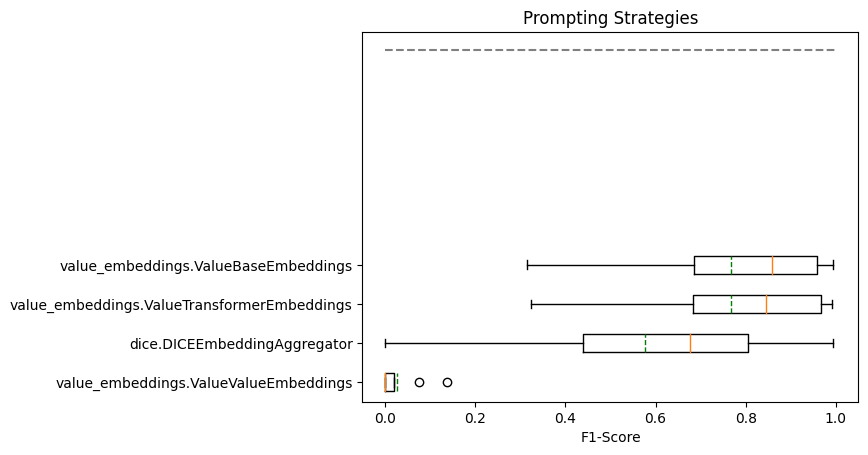

<Figure size 4000x1000 with 0 Axes>

In [3]:
#plt.figure(figsize=(50, 24))  # Adjust the figure size if needed

fig, ax = plt.subplots()
plt.figure(figsize=(40,10))
positions = []
# for i, col in enumerate(y_data):
#     positions.append(i*3+1)
#     mean = means[i]
#     ax.annotate(f'Mean: {mean:.2f}', xy=(-0, i+0.9), xytext=(0, 0),
#              textcoords='offset points')#, ha='left', va='center')

#plt.tick_params(axis='y', which='major', labelsize=3)
ax.boxplot(y_data, showmeans=True, meanline=True, meanprops={'color': 'green', 'linewidth': 1}, vert=False, )
ax.set_yticklabels(labels, ha='right')
ax.set_xlabel("F1-Score")
ax.set_title("Prompting Strategies")
ax.hlines([9.5], 0, 1, colors="grey", linestyles="dashed")
plt.tight_layout()
#plt.subplots_adjust(wspace=10) 
#ax.tick_params(axis="y", which="both", left=True, right=False, labelleft=False, labelright=False)
ax.set_xlim(-0.05, 1.05)
# Save the plot as an image (choose the desired format, e.g., PNG, PDF, etc.)
#plt.savefig('prompts_boxplotgrid_inified.png')  # Change the filename and extension accordingly
# Show the plot (optional)
plt.show()

In [4]:
# algorithm,collection,dataset,algo_training_type,algo_input_dimensionality,dataset_training_type,dataset_input_dimensionality,train_preprocess_time,train_main_time,execute_preprocess_time,execute_main_time,execute_postprocess_time,status,error_message,repetition,hyper_params,hyper_params_id,ROC_AUC,PR_AUC,RANGE_PR_AUC,AVERAGE_PRECISION,overall_time,error_category,algo_family,algo_area,algo_display_name
# ARIMA,GutenTAG,cbf-combined-diff-1,GHA,UNIVARIATE,NumbER,UNIVARIATE,,,,71.41411137580872,,Status.OK,,1,"{""differencing_degree"": 1, ""distance_metric"": ""twed"", ""max_lag"": 1000, ""max_p"": 5, ""max_q"": 5, ""p_start"": 1, ""q_start"": 1, ""random_state"": 42, ""window_size"": 100}",c65230762e5361a11b4faac7164f95bf,0.8153191489361702,0.4652479398325147,0.4532154876827748,0.4547417361111111,71.41411137580872,- OK -,forecasting,Statistics (Regression & Forecasting),ARIMA
result_df["algo_display_name"] = result_df["algorithm"]
result_df["algo_training_type"] = result_df["matching_solution"]
result_df["precision"] = result_df["precision_not_closed"]
result_df["f1"] = result_df["f1_not_closed"]
result_df["recall"] = result_df["recall_not_closed"]
result_df["algo_input_dimensionality"] = "TEST"
result_df["dataset_training_type"] = "TEST"
result_df["dataset_input_dimensionality"] = "TEST"
result_df["train_preprocess_time"] = 0
result_df["error_category"] = "- OK -"
result_df["algo_family"] = "forecasting"
result_df["algo_area"] = "Statistics (Regression & Forecasting)"
result_df["collection"] ="TEST"
#result_df.to_csv("result_df.csv", index=False)

In [5]:
result_df["algo_display_name"].unique()

array(['value_embeddings.ValueBaseEmbeddings',
       'value_embeddings.ValueTransformerEmbeddings',
       'value_embeddings.ValueValueEmbeddings',
       'dice.DICEEmbeddingAggregator'], dtype=object)

In [6]:
rename = {
     'pair_based_ditto_formatter': 'Naive',
     'pair_based_ditto_formatter_scientific': 'NaiveScientific',
     'complete_prompt_formatter': 'Distance',
     'complete_prompt_formatter_scientific': 'DistanceScientific',
     'complete_prompt_formatter_min_max_scaled': 'MinMaxDistance',
     'text_sim_formatter': 'TextualDistance',
     'textual_prompt_formatter': 'AttributePair',
     'textual_scientific': 'AttributePairScientific',
     'textual_min_max_scaled': 'AttributePairMinMax',
     'deep_matcher': 'DeepMatcher',
     'ditto': 'Ditto',
     'value_embeddings.ValueBaseEmbeddings': 'FCL-Embeddings',
       'value_embeddings.ValueTransformerEmbeddings': 'Transformer-Embeddings',
       'value_embeddings.ValueValueEmbeddings': 'Value-Embeddings',
       'dice.DICEEmbeddingAggregator': 'DICE-Embeddings'
}
#rename all values of result_df in column algorithm according to rename
result_df['algorithm'] = result_df['algorithm'].apply(lambda x: rename[x])
result_df.to_csv("result_embeddings_df.csv", index=False)

In [10]:
def _compute_boxplot_values(algo_name: str, values: np.ndarray) -> dict:
        values = np.sort(values)
        print(values)
        q1 = np.quantile(values, 0.25)
        q3 = np.quantile(values, 0.75)
        iqr = q3 - q1
        return {
            "name": algo_name,
            "lower_whisker": np.min(values),
            "upper_whisker": np.max(values),
            "lower_quartile": q1,
            "upper_quartile": q3,
            "median": np.median(values),
            "average": np.mean(values),
            "sample_size": len(values)
        }

In [13]:
for algorithm in result_df["algorithm"].unique():
    values = result_df[result_df["algorithm"] == algorithm]["f1_not_closed"].values
    print(algorithm, result_df[result_df["algorithm"] == algorithm])
    print(f"Algorithm: {algorithm}, Values: {_compute_boxplot_values(algorithm, values)}")

FCL-Embeddings                  dataset  f1_not_closed  recall_not_closed  \
0       2MASS_small_no_n       0.956781           0.946000   
1  baby_products_numeric       0.416833           0.468199   
2         books3_numeric       0.994066           0.990583   
3            earthquakes       0.774209           0.766130   
4          protein_small       0.314276           0.488523   
5              vsx_small       0.965894           0.983277   
6             x2_numeric       0.915922           0.945156   
7             x3_numeric       0.801387           0.804110   

   precision_not_closed  training_time matching_solution       algorithm  \
0              0.968816      15.288177            NumbER  FCL-Embeddings   
1              0.425636       1.480142            NumbER  FCL-Embeddings   
2              0.997674       4.725837            NumbER  FCL-Embeddings   
3              0.784292      16.629607            NumbER  FCL-Embeddings   
4              0.289391      54.731963        